In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
from matplotlib import colormaps
import matplotlib.pyplot as plt
import EpiClockInvasiveBRCA.src.util as epi_util
from MolecularClocks.src.invasiveCpGs_consts import getConsts

consts = getConsts()

In [2]:
beta_values = {}
sample_map = {}
patients_bothSamplesPure = {}
samples_from_purePairs = {}
figure_outdir = os.path.join('figures', 'multi-sample')
if not os.path.exists(figure_outdir):
    os.mkdir(figure_outdir)

In [3]:
# Figure parameters

# scale factor
sf = 0.4

square_figsize = np.array([5, 4])
figsize = np.array([9, 7])
labelfontsize = 25
ticksfontsize = 18
opacity = 0.8

sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

## Primary-metastasis samples

In [4]:
proj_dir = os.path.join(consts['official_indir'], 'Reyngold')

sample_map['Reyngold'] = pd.read_table(os.path.join(proj_dir, 'sample_map.txt'), index_col=0)
patients_bothSamplesPure['Reyngold'] = np.loadtxt(os.path.join(proj_dir, 'patients_bothSamplesPure.txt'), dtype=str)
beta_values['Reyngold'] = pd.read_table(os.path.join(proj_dir, 'beta_values_balanced_CpGs_pureSamples.txt'), index_col=0)
samples_from_purePairs['Reyngold'] = sample_map['Reyngold'].index[sample_map['Reyngold']['unique patient id'].isin(patients_bothSamplesPure['Reyngold'])].values

In [5]:
correlation_df = pd.DataFrame(index=samples_from_purePairs['Reyngold'], columns=samples_from_purePairs['Reyngold'], data=float('nan'))
n_GSMs = correlation_df.shape[0]

for i in range(n_GSMs):
    GSM_i = samples_from_purePairs['Reyngold'][i]
    correlation_df.loc[GSM_i, GSM_i] = 1
    for j in range(i+1, n_GSMs):
        GSM_j = samples_from_purePairs['Reyngold'][j]
        ser_i = beta_values['Reyngold'][GSM_i]
        ser_j = beta_values['Reyngold'][GSM_j]
        res, n_used = epi_util.pearsonCorrelation(ser_i, ser_j, get_n_used=True)
        if n_used >= 10:
            correlation_df.loc[GSM_i, GSM_j] = res.rvalue
            correlation_df.loc[GSM_j, GSM_i] = res.rvalue

In [6]:
sample_map_copy = sample_map['Reyngold'][['unique patient id', 'sample type']].copy()
sample_map_copy['sample type'] = sample_map_copy['sample type'].map({'primary tumor':'Tum', 'lymph node metastasis':'Met'})
GSM_to_heatmap_label_mapper = sample_map_copy.loc[samples_from_purePairs['Reyngold']].apply(lambda x:': '.join(x), axis=1)
correlation_df = correlation_df.rename(columns=GSM_to_heatmap_label_mapper).rename(index=GSM_to_heatmap_label_mapper)

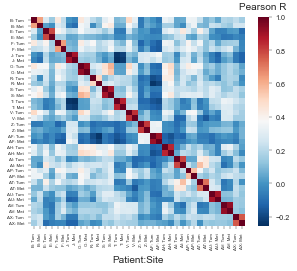

In [7]:
fig, ax = plt.subplots(1, 1, figsize=square_figsize * 2.4 * sf)

cmap = colormaps['RdBu'].reversed()
cmap.set_bad('lightgray', 1.)
sns.heatmap(ax=ax, data=correlation_df, cmap=cmap, cbar_kws={'label':'Pearson R'})
cbar_ax = ax.figure.axes[-1]
cbar_ax.yaxis.label.set_size(labelfontsize * sf)
cbar_ax.tick_params(labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

cbar_ax.set_ylabel(cbar_ax.get_ylabel(), rotation=0)
cbar_ax.yaxis.set_label_coords(0.4, 1.07)

# ax.set_title('Cohort T4 Intrapatient Methylation Correlation of Primary Tumors and Metastases', fontsize=labelfontsize * sf)
ax.set_xlabel('Patient:Site', fontsize=labelfontsize * sf)
ax.xaxis.set_label_coords(0.5, -0.14)
ax.tick_params(axis='both', labelsize=ticksfontsize * 0.6 * sf, width=sf, length=8 * sf)
ticks = np.sort(np.concatenate([ax.get_xticks(), ax.get_xticks() + 1]))
ax.set_xticks(ticks, correlation_df.index)
ax.set_yticks(ticks, correlation_df.index)

fig.savefig(os.path.join(figure_outdir, 'prim-met_heatmap.pdf'), format='pdf', pad_inches=0.1)

In [8]:
c_beta = 1 - beta_values['Reyngold'].std(axis=0)
c_beta_table_by_patient = sample_map['Reyngold'].reset_index().pivot(index='unique patient id', columns='sample type', values='index')
c_beta_table_by_patient['lymph node metastasis'] = c_beta_table_by_patient['lymph node metastasis'].map(c_beta)
c_beta_table_by_patient['primary tumor'] = c_beta_table_by_patient['primary tumor'].map(c_beta)

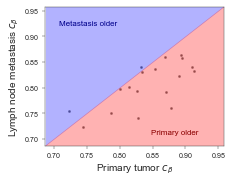

In [9]:
c_beta_table_by_patient = c_beta_table_by_patient.loc[patients_bothSamplesPure['Reyngold']]
outfile_name = 'prim-met_age_comparison.pdf'


fig, ax = plt.subplots(figsize=square_figsize * 1.6 * sf)

pts_range = (c_beta_table_by_patient.min().min()*0.95, c_beta_table_by_patient.max().max()*1.05)
pts_arr = np.linspace(pts_range[0], pts_range[1], 100)

sns.scatterplot(ax=ax, data=c_beta_table_by_patient, x='primary tumor', y='lymph node metastasis', color='dimgray',
               s=50 * sf**2)

ax.set_xlim(pts_range[0], pts_range[1])
ax.set_ylim(pts_range[0], pts_range[1])

ax.fill_between(pts_range, pts_range, 1, alpha=0.3, color='blue', lw=0)
ax.fill_between(pts_range, 0, pts_range, alpha=0.3, color='red', lw=0)

ax.set_xlabel(ax.get_xlabel().capitalize() + ' $c_β$', fontsize=labelfontsize * sf)
ax.set_ylabel(ax.get_ylabel().capitalize() + ' $c_β$', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

ax.text(pts_range[0]*1.03, pts_range[1]*0.96, 'Metastasis older',
        ha="left", va="bottom", fontfamily='sans-serif', color='darkblue',
        fontsize=labelfontsize * 0.8 * sf)
ax.text(pts_range[1]*0.96, pts_range[0]*1.03, 'Primary older',
        ha="right", va="bottom", fontfamily='sans-serif', color='darkred',
        fontsize=labelfontsize * 0.8 * sf)

plt.savefig(os.path.join(figure_outdir, outfile_name), format='pdf', pad_inches=0.1)

## Bifocal tumor samples

In [10]:
proj_dir = os.path.join(consts['official_indir'], 'Desmedt')

sample_map['Desmedt'] = pd.read_table(os.path.join(proj_dir, 'sample_annotations_clean.txt'), index_col=0, dtype=str)
patients_bothSamplesPure['Desmedt'] = np.loadtxt(os.path.join(proj_dir, 'patients_bothSamplesPure.txt'), dtype=str)
beta_values['Desmedt'] = pd.read_table(os.path.join(proj_dir, 'beta_values_balanced_CpGs_pureSamples.txt'), index_col=0)
samples_from_purePairs['Desmedt'] = sample_map['Desmedt'].index[sample_map['Desmedt']['patient'].isin(patients_bothSamplesPure['Desmedt'])].values

In [11]:
correlation_df = pd.DataFrame(index=samples_from_purePairs['Desmedt'], columns=samples_from_purePairs['Desmedt'], data=float('nan'))
n_GSMs = correlation_df.shape[0]

for i in range(n_GSMs):
    GSM_i = samples_from_purePairs['Desmedt'][i]
    correlation_df.loc[GSM_i, GSM_i] = 1
    for j in range(i+1, n_GSMs):
        GSM_j = samples_from_purePairs['Desmedt'][j]
        ser_i = beta_values['Desmedt'][GSM_i]
        ser_j = beta_values['Desmedt'][GSM_j]
        res, n_used = epi_util.pearsonCorrelation(ser_i, ser_j, get_n_used=True)
        if n_used >= 10:
            correlation_df.loc[GSM_i, GSM_j] = res.rvalue
            correlation_df.loc[GSM_j, GSM_i] = res.rvalue

In [12]:
GSM_to_heatmap_label_mapper = sample_map['Desmedt'].loc[samples_from_purePairs['Desmedt'], ['patient', 'foci']].apply(lambda x:':'.join(x), axis=1)
correlation_df = correlation_df.rename(columns=GSM_to_heatmap_label_mapper).rename(index=GSM_to_heatmap_label_mapper)

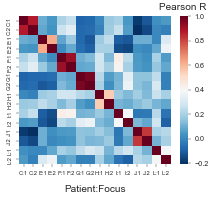

In [13]:
fig, ax = plt.subplots(1, 1, figsize=square_figsize * 1.7 * sf)

cmap = colormaps['RdBu'].reversed()
cmap.set_bad('lightgray', 1.)
sns.heatmap(ax=ax, data=correlation_df, cmap=cmap, cbar_kws={'label':'Pearson R'})
cbar_ax = ax.figure.axes[-1]
cbar_ax.yaxis.label.set_size(labelfontsize * sf)
cbar_ax.tick_params(labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

cbar_ax.set_ylabel(cbar_ax.get_ylabel(), rotation=0)
cbar_ax.yaxis.set_label_coords(0.4, 1.09)

# ax.set_title('Cohort T3 Intrapatient Methylation Correlation', fontsize=20)
ax.set_xlabel('Patient:Focus', fontsize=labelfontsize * sf)
ax.xaxis.set_label_coords(0.5, -0.14)

ax.tick_params(axis='both', labelsize=ticksfontsize * 0.8 * sf, width=sf, length=8 * sf)
ticks = np.sort(np.concatenate([ax.get_xticks(), ax.get_xticks() + 1]))
ax.set_xticks(ticks, correlation_df.index)
ax.set_yticks(ticks, correlation_df.index)

fig.savefig(os.path.join(figure_outdir, 'bifocal_heatmap.pdf'), format='pdf', pad_inches=0.1)

In [14]:
c_beta = 1 - beta_values['Desmedt'].std(axis=0)
c_beta_table_by_patient = sample_map['Desmedt'].reset_index().pivot(index='patient', columns='foci', values='index')
c_beta_table_by_patient['1'] = c_beta_table_by_patient['1'].map(c_beta)
c_beta_table_by_patient['2'] = c_beta_table_by_patient['2'].map(c_beta)

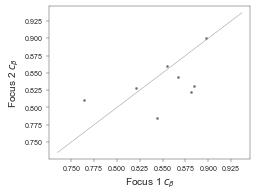

In [15]:
# change x and y lim to be square

outfile_name = 'bifocal_age_comparison.pdf'

fig, ax = plt.subplots(figsize=figsize * sf)

pts_range = (c_beta_table_by_patient.min().min()*0.95, c_beta_table_by_patient.max().max()*1.05)
pts_arr = np.linspace(pts_range[0], pts_range[1], 100)
# pts_arr = np.linspace(0, 1, 100)

sns.scatterplot(ax=ax, data=c_beta_table_by_patient, x='1', y='2', color='dimgray', s=50 * sf**2)

ax.set_xlabel('Focus 1 $c_β$', fontsize=labelfontsize * sf)
ax.set_ylabel('Focus 2 $c_β$', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

ax.set_xlim(pts_range[0], pts_range[1])
ax.set_ylim(pts_range[0], pts_range[1])

ax.plot(pts_arr[4:-4], pts_arr[4:-4], color="grey", linestyle='solid', linewidth=1.0 * sf)

plt.savefig(os.path.join(figure_outdir, outfile_name), format='pdf')